In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [2]:
# Function to convert to milliseconds
def to_gb(val):
    if pd.isna(val):
        return None
    val = str(val).strip().lower()

    if val.endswith("gb"):
        return float(val.replace("gb", "").strip())
    elif val.endswith("mb"):
        return float(val.replace("mb", "").strip()) / 1000.0
    else:
        # assume it's already GB
        return float(val)


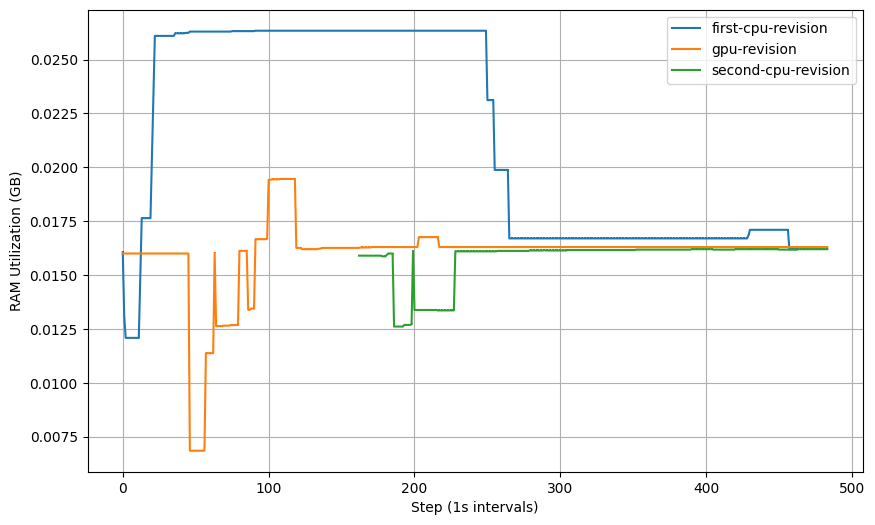

In [3]:
# RAM Utilization Auto

# Load all CSV files
# Load CSVs
csv_files_auto_ram = glob.glob("./data/auto/*resources.csv")

dfs_auto_ram = []
for file in csv_files_auto_ram:
    df = pd.read_csv(file, usecols=["ram-cpu-1_user-container", "ram-gpu_user-container", "ram-cpu-2_user-container"])
    df["ram-cpu-1_user-container"] = df["ram-cpu-1_user-container"].apply(to_gb)
    df["ram-gpu_user-container"] = df["ram-gpu_user-container"].apply(to_gb)
    df["ram-cpu-2_user-container"] = df["ram-cpu-2_user-container"].apply(to_gb)
    dfs_auto_ram.append(df)

# Combine into one DataFrame
combined_auto = pd.concat(dfs_auto_ram, axis=1)

means_auto_cpu_container_1 = combined_auto["ram-cpu-1_user-container"].mean(axis=1)
means_auto_gpu_container = combined_auto["ram-gpu_user-container"].mean(axis=1)
means_auto_cpu_container_2 = combined_auto["ram-cpu-2_user-container"].mean(axis=1)

plt.figure(figsize=(10,6))

plt.plot(means_auto_cpu_container_1.index, means_auto_cpu_container_1, marker=",", label="first-cpu-revision")
plt.plot(means_auto_gpu_container.index, means_auto_gpu_container, marker=",", label="gpu-revision")
plt.plot(means_auto_cpu_container_2.index, means_auto_cpu_container_2, marker=",", label="second-cpu-revision")

plt.xlabel("Step (1s intervals)")
plt.ylabel("RAM Utilization (GB)")
plt.legend()
plt.grid(True)
plt.show()



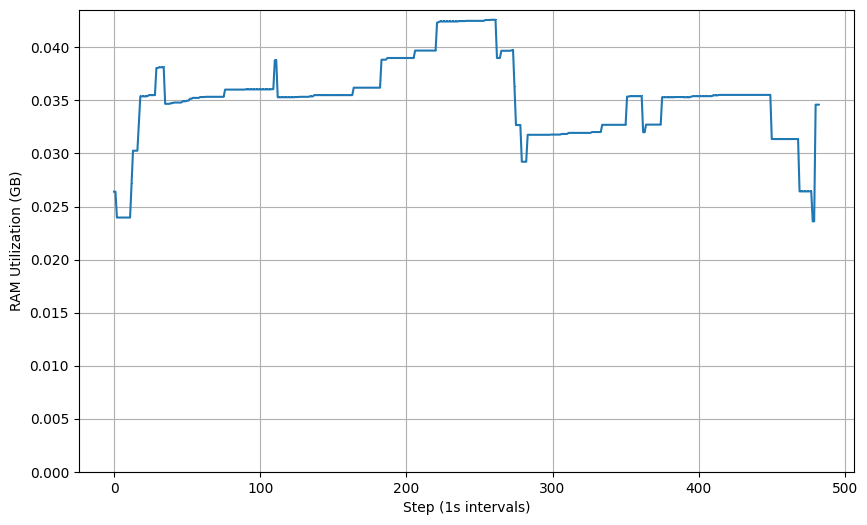

In [4]:
# RAM Utilization CPU mode

# Load all CSV files
csv_files_cpu = glob.glob("./data/cpu/*resources.csv")

# clean
dfs_cpu = []
for file in csv_files_cpu:
    df = pd.read_csv(file, usecols=["ram_user-container"])
    df["ram_user-container"] = df["ram_user-container"].apply(to_gb)
    dfs_cpu.append(df)


combined_cpu = pd.concat(dfs_cpu, axis=1)

means_cpu = combined_cpu.mean(axis=1)

plt.figure(figsize=(10,6))

plt.plot(means_cpu.index, means_cpu, marker=",")

plt.xlabel("Step (1s intervals)")
plt.ylabel("RAM Utilization (GB)")
plt.ylim(bottom=0)  # y-axis starts at 0
# plt.legend()
plt.grid(True)
plt.show()

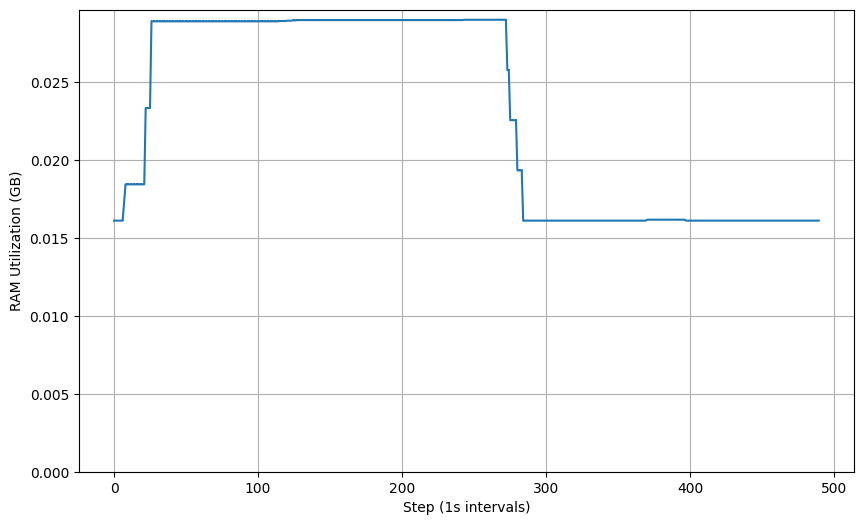

In [5]:
# RAM Utilization GPU mode

# Load all CSV files
csv_files_gpu = glob.glob("./data/gpu/*resources.csv")

# clean
dfs_gpu = []
for file in csv_files_gpu:
    df = pd.read_csv(file, usecols=["ram_user-container"])
    df["ram_user-container"] = df["ram_user-container"].apply(to_gb)
    dfs_gpu.append(df)


combined_gpu = pd.concat(dfs_gpu, axis=1)

means_gpu = combined_gpu.mean(axis=1)

pd.set_option('display.max_rows', None)

plt.figure(figsize=(10,6))

# only between index 200 and 400
# means_cpu = means_cpu[25:75]
# print(means_ram)

plt.plot(means_gpu.index, means_gpu, marker=",")

plt.xlabel("Step (1s intervals)")
plt.ylabel("RAM Utilization (GB)")
plt.ylim(bottom=0)  # y-axis starts at 0
# plt.legend()
plt.grid(True)
plt.show()

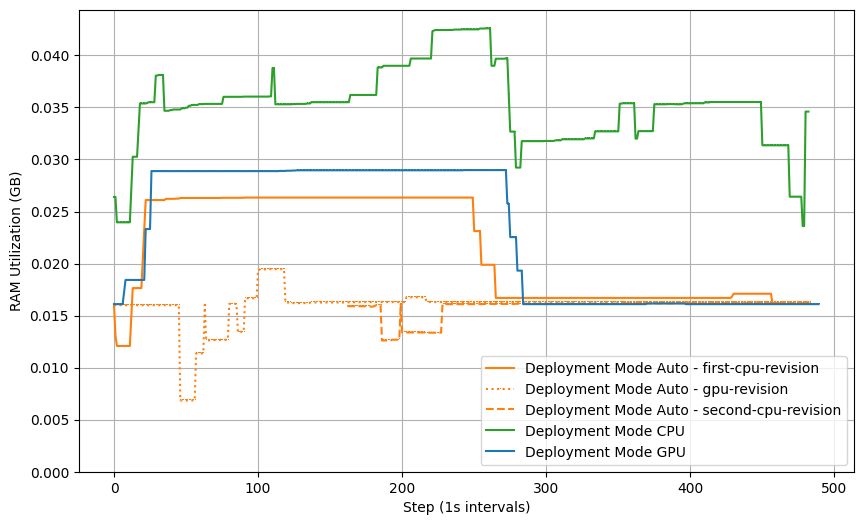

In [6]:
plt.figure(figsize=(10,6))

line1, = plt.plot(means_auto_cpu_container_1.index, means_auto_cpu_container_1,
                  marker=",", label="Deployment Mode Auto - first-cpu-revision", color="tab:orange")
plt.plot(means_auto_gpu_container.index, means_auto_gpu_container,
         marker=",", linestyle=":", color=line1.get_color(),
         label="Deployment Mode Auto - gpu-revision")
plt.plot(means_auto_cpu_container_2.index, means_auto_cpu_container_2,
         marker=",", linestyle="--", color=line1.get_color(),
         label="Deployment Mode Auto - second-cpu-revision")

plt.plot(means_cpu.index, means_cpu, marker=",", label="Deployment Mode CPU", color="tab:green")

plt.plot(means_gpu.index, means_gpu, marker=",", label="Deployment Mode GPU", color="tab:blue")

plt.xlabel("Step (1s intervals)")
plt.ylabel("RAM Utilization (GB)")
plt.ylim(bottom=0)  # y-axis starts at 0
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Export to csv

df_lines = pd.DataFrame({
    "AUTO-first-cpu-revision": means_auto_cpu_container_1,
    "AUTO-gpu-revision": means_auto_gpu_container,
    "AUTO-second-cpu-revision": means_auto_cpu_container_2,
    "CPU": means_cpu,
    "GPU": means_gpu
})

# Save to CSV
df_lines.to_csv("ram.csv", index_label="Index")



In [8]:
# Get cost rates

ram_rate = 0.000004  # per second per GiB-Seconds

# convert to GB
ram_rate_gb = ram_rate / 1.07374  # per second per GB

mean_ram_cpu = means_cpu.mean()  # since auto mode is always on CPU
mean_ram_gpu = means_gpu.mean()

print(f"Mean CPU Cpu: {mean_ram_cpu}")
print(f"Mean CPU GPU: {mean_ram_gpu}")

cost_cpu = mean_ram_cpu * ram_rate
cost_gpu = mean_ram_gpu * ram_rate
print(f"Estimated cost per second in CPU mode: ${cost_cpu:.8f}")
print(f"Estimated cost per second in GPU mode: ${cost_gpu:.8f}")

Mean CPU Cpu: 0.035178726708074544
Mean CPU GPU: 0.022830520408163267
Estimated cost per second in CPU mode: $0.00000014
Estimated cost per second in GPU mode: $0.00000009
